# This file contains implementation and detailed explanation of key functions
## Extracting embeddings from a language model (BERT)
+ **Embeddings** refer to **vector representations** of the input text. Based on the type of text, there can be word embeddings, sentence embeddings, document embeddings, etc. Here, we are concerned with document level embeddings, meaning that we will generate one embedding representation for each essay. You can learn more about the embeddings from [this link](https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently). 
+ The embeddings are extracted from a transformer-based language model, (in this case, deberta-v3-large). We use `transformer` library from Huggingface to do this.
+ Input to the model is raw text. Text needs to be preprocessed with a **tokenizer** that is shipped with the model. The model has a restriction regarding the maximum input size (token count).
+ Output of the model is a tensor consisting of the last layer hidden state of the model. The size of the tensor differs with the model. From here, there are different methods of extracting embeddings from which you can choose. 
### First we import relevant libraries

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch

### and prepare some text as example

In [6]:
t = 'As far as I am cencerned, reading is getting more and more important in our life. there are a lot of advantages of reading books. First of all, reading books is one of the important ways to being knowledged. By reading books, we can learn lots of information of modern science, broden the vison of us. We can also get the imformation of the past and gain valuable experience from history so that we can create a better future. secendly, we can get entertainment by reading books. when we are reading something which is interesting for us, wo could get happiness and be willing to reading more about it. As the time passes, we have already establish the habit of reading this kind of the books, which is a perfect way for us to have a relax. Last but not least, reading can cultivate sentiment. As we learn more and more storys and the experience of others, we gradually know how to be better person. In some ways, it makes our future life easier. All in all, there are many benifits we could find through reading. So just get reading as your habit'

### It is important to make sure that CUDA is working properly
+ This needs to be True for pytorch to use GPU acceleration (provided that you have an Nvidia GPU that is CUDA compatible, and you have installed both pytorch and CUDA correctly, and their versions match), otherwise the model will be running on your CPU, which is extremely **slow**. If you have an AMD GPU, you can Google for help about GPU acceleration. 

In [8]:
torch.cuda.is_available() 

True

### Then we load the model and tokenizer
+ The `transformer` library will download the model automatically if you provide it with the name of the model. Here, we load the model locally by providing a path to where the model is stored. 

In [9]:
model = AutoModel.from_pretrained('model/deberta-v3-large')
tokenizer = AutoTokenizer.from_pretrained('model/tokenizer/deberta-v3-large')
# If you did not download the model:
# model = AutoModel.from_pretrained("microsoft/deberta-v3-large")
# tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')

### Next we tokenize the text as input to the model
These things happen at the same time with tokenizing:
+ **Adding special token**: Add a special `CLS` token at the start of the text. This token is supposed to catch all the information of the text, and can be further used in classification or regression tasks. 
+ **Max length**: Transformer model has an innate restriction regarding maximum input size. (The original model is 512 tokens, but later models can accept longer sequences). It is important to note that memory consumption increases **cubically** with respect to sequence length.
+ **Padding/truncation**: Align text length to `man_length` by adding 0s (padding) or removing tokens (truncation)

In [15]:
input = tokenizer(t,
        add_special_tokens=True, # add a special CLS token at the start of the text
        max_length=512,          # max input sequence length, longer sequence length will increase memory consumption
        return_tensors='pt',     # return the result in pytorch tensor
        padding='max_length',    # add 0 at the end of the text if shorter than 512 tokens
        truncation=True)         # truncate text longer than 512 tokens

The result is a dictionary, we need the two following:
+ `input_ids`: a 512 long list consisting of the ids of the text, each id corresponds to one token.
+ `attention_mask`: tells the model that the 0s at the end of the text (padding) is not important and should be neglected.

In [19]:
input['input_ids']

tensor([[    1,   463,   659,   283,   273,   481, 81230, 18632, 14324,   261,
          1077,   269,   646,   310,   263,   310,   539,   267,   316,   432,
           260,   343,   281,   266,   509,   265,  5228,   265,  1077,  1116,
           260,  1244,   265,   305,   261,  1077,  1116,   269,   311,   265,
           262,   539,  1029,   264,   411,  1118,   407,   260,   927,  1077,
          1116,   261,   301,   295,   799,  1738,   265,   439,   265,  1252,
          1693,   261, 18571,  5576,   262, 21161,   935,   265,   381,   260,
           345,   295,   327,   350,   262,  6438, 45887,   265,   262,   695,
           263,  2088,  2869,   517,   292,   820,   324,   272,   301,   295,
           676,   266,   493,   723,   260, 15455,  3308,   701,   261,   301,
           295,   350,  3280,   293,  1077,  1116,   260,   335,   301,   281,
          1077,   491,   319,   269,  1257,   270,   381,   261, 20514,   387,
           350,  5116,   263,   282,  2608,   264,  

In [18]:
input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

### Now we are ready to run the model

In [21]:
input.to('cuda')      # move all input data to GPU 
model.to('cuda')      # move the model to GPU 
with torch.no_grad(): # we only do model inference(no training is required), this saves memory
    out = model(input['input_ids'],input['attention_mask'])  # run the model
embedding = out.last_hidden_state.detach().cpu() # we only need last layer hidden state as output of the model, move that back to cpu

In [22]:
del out 
torch.cuda.empty_cache()  # they are no longer needed, you can clear cuda cache to save memory

### Finally, extract the embeddings
+ The output of the model is a 1 (batch size) * 512 (sequence length) * 1024 (model specific) tensor, meaning that each token is represented by a 1024 dimension vector.   
+ [This picture](https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently) visualizes the output, though in + this case the tensor is 2000 (batch size) * 66 (sequence length) * 768 (model specific)  
+ What we want is a 1024 dimension vector for each essay
![](https://miro.medium.com/max/2120/1*p6PgpOV74U_qLrzr-1_4Zg.png)

In [24]:
embedding.size()

torch.Size([1, 512, 1024])

#### CLS token
+ the idea is `CLS` token would have captured the entire context and would be sufficient for simple downstream tasks such as classification.
+ It is very easy to get

In [27]:
embedding_CLS = embedding[:,0]
embedding_CLS.size()

torch.Size([1, 1024])

#### Mean pooling
+ Also, we can take a position-wise average of each of the 1024 dimension in the output. (Meaning that in each of the 1024 dimension, we take the average along the 512 token long sequence)
+ First, we need the attention mask so that paddings are not accounted for when taking average

In [46]:
attention_mask = input['attention_mask'].unsqueeze(-1).expand(embedding.size()).detach().cpu()
# we need to turn attention mask also into a 1 * 512 * 1024 tensor
# it is originally 1 * 512
# unsqueeze(-1) makes it 1 * 512 * 1
# then expand it to 1 * 512 * 1024
attention_mask

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

+ Next, for each of the 1024 dimension, sum along the 512 positions of tokens, divided by the count of 'real' tokens (non-zero), to get average

In [49]:
embedding_sum = torch.sum(attention_mask * embedding,1) # summing along the second axis (along the sequence), by multiplying the two tensors, paddings will be reduced to 0
mask_sum = attention_mask.sum(1) # count of real tokens (non-zero)
mask_sum.clamp(min=1e-9)         # prevents division by 0
embedding_MeanP = embedding_sum/mask_sum
embedding_MeanP.size()

torch.Size([1, 1024])

There are other methods of extracting embeddings, but here we only introduce the above two. They are easy to get and perform reasonably well.
## Computing syntactic complexity measures
+ We use `spaCy` to process the text, including pos tagging, dependency parsing, etc. 

In [8]:
import spacy
import nltk              # tree data structure
from supar import Parser # constituency parser

#### Again, make sure that the model is running on GPU before loading the model

In [9]:
from thinc.api import set_gpu_allocator, require_gpu 
set_gpu_allocator("pytorch")
require_gpu(0)

True

In [10]:
# To download the model, you need to run the following in your terminal beforehand:
# python -m spacy download en_core_web_trf
NLP = spacy.load('en_core_web_trf')  
SuPar = Parser.load('crf-con-en')

### Using spacy is very easy. Computation of most measures are trivial (such as counting pos, dependency tags, etc.) and can be done in one traverse.

In [8]:
doc = NLP(t)
for sent in doc.sents:
    # do something
    for token in sent:
        # do something 
        pass
# refer to FeatureExtraction class in functions.py for more details

### Things get tricky when it comes to counting phrases. Here I use an algorithm based on depth-first searching (dfs)
#### First we need constituency parsing 

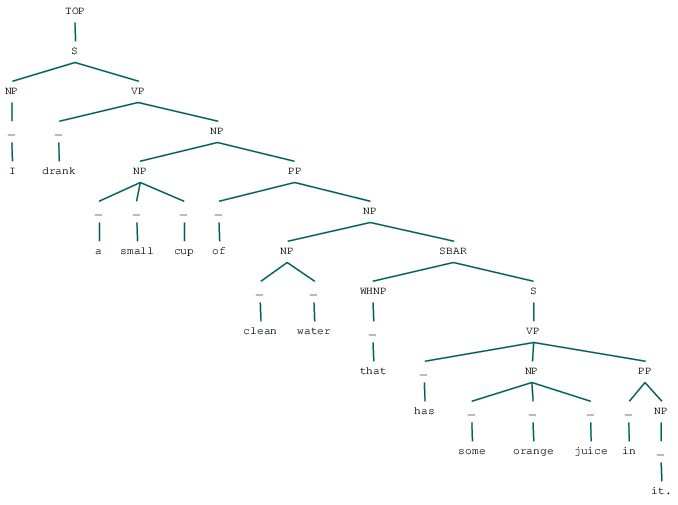

In [25]:
t_token ='I drank a small cup of clean water that has some orange juice in it.'.split()                         # tokens in one sentence
tree = str(SuPar.predict(t_token,prob=True,verbose= False).sentences[0])  # parsing
nltk_tree = nltk.Tree.fromstring(tree)                               # create constituency tree (we can do this with nltk conveniently)
nltk_tree

#### Consider a simple case, find all VPs
+ This is a simple recursion function, each subtree is also a tree, so finding VPs in a subtree is just a smaller instance of the same problem.
+ Here we only consider VP labels

In [12]:
def FindPhrase(tree):
    count = 0               # count of VPs
    if tree.label() == '_': # end of tree
        return 0
    if tree.label() == 'VP':
        count += 1          # found a VP
    for i in range(len(tree)): # traverse subtrees
        count += FindPhrase(tree[i]) # tree[i] is a subtree of the tree, use recursion to find VPs in this subtree
    return count            # return the result
FindPhrase(nltk_tree)

2

#### We can expand this function a little to accommodate other phrases

In [8]:
def FindPhrase(tree,phrase_label):
    # we pass an argument to specify which kind of phrase we want to find
    count = 0               # count of VPs
    if tree.label() == '_': # end of tree
        return 0
    if tree.label() == phrase_label:
        count += 1          # found a VP
    for i in range(len(tree)): # traverse subtrees
        count += FindPhrase(tree[i],phrase_label) # tree[i] is a subtree of the tree, use recursion to find VPs in this subtree
    return count            # return the result
FindPhrase(nltk_tree,'NP')

6

#### Notice that there are a few problems, we want phrases, but single words are also labelled XPs
+ Rule 1: $len(XP) > 1$

In [29]:
def FindPhrase(tree,phrase_label):
    count = 0               # count of VPs
    if tree.label() == '_': # end of tree
        return 0
    if tree.label() == phrase_label:
        if len(tree) > 1:
            count += 1          
    for i in range(len(tree)): # traverse subtrees
        count += FindPhrase(tree[i],phrase_label) # tree[i] is a subtree of the tree, use recursion to find VPs in this subtree
    return count            # return the result
FindPhrase(nltk_tree,'NP')

5

#### Also, we don't want 'a small cup', 'clean water' and 'a small cup of clean water' counted as three NPs.
+ Rule 2: Do not search XP's direct XP child

In [31]:
def FindPhrase(tree,phrase_label):
    count = 0               # count of VPs
    flag = False            # mark if we find XP
    if tree.label() == '_': # end of tree
        return 0
    if tree.label() == phrase_label:
        if len(tree) > 1:
            count += 1        
            flag = True
    for i in range(len(tree)): # traverse subtrees
        if tree[i].label() == phrase_label and flag:  # If we find XP in XP's direct child
            continue # skip this subtree
        count += FindPhrase(tree[i],phrase_label) # tree[i] is a subtree of the tree, use recursion to find VPs in this subtree
    return count            # return the result
FindPhrase(nltk_tree,'NP')     

3

## Tree kernel
### Definition
if labels of $n_1$ and $n_2$ are the same:
$$
C(n_1,n_2) = 1 + \sum_{J_1,J_2,|J_1| = |J_2|}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}])
$$
we are summing over all pairs of possible subsequences of children of all possible length (smaller than shorter tree length), allowing partial trees with gaps   
With decay factors :
$$
C(n_1,n_2) = \mu (\lambda^2 + \sum_{J_1,J_2,|J_1| = |J_2|} \lambda^{(d(J_1)+d(J_2))}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}]))
$$
where
$$
d(J_1) = J_{1l(J_1)} - J_{11} + 1
$$
if they are different:
$$
C(n_1,n_2) = 0
$$
The tree kernel of $T_1$ and $T_2$ is:
$$
K(T_1,T_2) = \sum_{t_1\in N_{T_1}}\sum_{t_2\in N_{T_2}}C(t_1,t_2)
$$
with normalization
$$
K_{norm}(T_1,T_2) = \dfrac{K(T_1,T_2)}{\sqrt{K(T_1,T_1) \times K(T_2,T_2)}}
$$
### Implementation
#### This looks very complicated, let's start from the simple things

In [1]:
import math

In [2]:
def KernelFunction(t1,t2):          # this is C(t1,t2)
    # do something...
    return 0
def PartialTreeKernel(tree1,tree2): # this is K(T1,T2) 
    res = 0
    for t1 in tree1: 
        for t2 in tree2:
            res += KernelFunction(t1,t2) 
    return res
def normPTK(tree1,tree2):          # this is K_norm (T1,T2)
    return PartialTreeKernel(tree1,tree2)/math.sqrt(PartialTreeKernel(tree1,tree1)*PartialTreeKernel(tree2,tree2))

#### We need to change `PartialTreeKernel` a bit here, because arguments need to be passed as trees, not nodes

In [25]:
def PartialTreeKernel(tree1,tree2): # this is K(T1,T2) 
    res = 0
    for tokent1 in tree1:  # tree1 and tree2 and sentences from spacy doc, we build the trees manually: (node,[children])
        t1 = (tokent1,[i for i in tokent1.children if i.text.isalpha()])   # remove punctuations
        for tokent2 in tree2:
            t2 = (tokent2,[i for i in tokent2.children if i.text.isalpha()])  
            res += KernelFunction(t1,t2) 
    return res

#### In `KernelFunctioon`, first we convert trees from tokens to dependency tags, and do the simple case first (when the dependency labels are different, the output is simply 0)

In [ ]:
def KernelFunction(tree1,tree2):          # this is C(t1,t2)
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i]) # we pass tree1 and tree2, trees of token objects
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i]) # t1 and t2 are trees of dep labels
    if t1[0] == t2[0]:
        res = 0
        # do something
        return res
    else:
        return 0

#### Now we implement this part: 
$$
C(n_1,n_2) = 1 + \sum_{J_1,J_2,|J_1| = |J_2|}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}])
$$
The key is: **what is $\bold{ch_{n1}[J_{1i}]}$?**  
1. $ch_{n1}$ is the children sequence of $n1$, so $ch_{n1}[N]$ is the $N$ th child of $n1$
2. $J_1$ is some sequence, and $J_{1i}$ is its $i$ th element
3. We take the product over $1 <= i <= |J_1|$, where $|J_1|$ is the length of $|J_1|$

In [ ]:
def KernelFunction(tree1,tree2):          # this is C(t1,t2)
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i]) # we pass tree1 and tree2, trees of token objects
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i]) # t1 and t2 are trees of dep labels
    if t1[0] == t2[0]:
        res = 0
        # do something
        j1 = [] # j1 is some sequence
        j2 = []
        prod = 1
        for i in range(len(j1)):
            childt1 = tree1[1][j1[i]]
            childt2 = tree2[1][j2[i]]  # this is chn1[j1i]
            childtree1 = (childt1,[j for j in childt1.children if j.text.isalpha()])
            childtree2 = (childt2,[j for j in childt2.children if j.text.isalpha()]) # remember, arguments are passed as trees of token 
            prod = prod * KernelFunction(childtree1,childtree2)
        # do something
        return res
    else:
        return 0

#### Then, **what is $\bold{J_1}$?** 
1. $J_1$ is the **ordered index sequence** of $ch_{n1}$, meaning that it contains possible indices of children of $n_1$
2. If $|J_1| = l$ and $|ch_{n1}| = L, 1 \le J_{11} < J_{12} < ... < J_{1l} \le L$
3. Since $|J_1| = |J_2|, 1 \le l \le \min(|ch_{n1}|,|ch_{n2}|)$
4. For all possible $l$, $J_1$ could be **any subsequence** of length $l$ among $[1,2,...,L]$, meaning there are $C_L^l$ possible $J_1$. For example, if $L=5, l = 2$, $J_1$ could be: $[1,2],[2,3],[1,3],...,[4,5]$. 
5. For two given trees, we need to traverse **all possible pairs of** $J_1$ and $J_2$   
Therefore, we need a helper function to get all possible subsequences of length $l$ among $[1,2,...,L]$. Again, we use recursion here. For each element $m$ in $[1,2,...,L]$, get all possible subsequences of length $l-1$ among $[m,m+1,...,L]$, then insert $m$ at the start of each of the sequences

In [4]:
def GetAllComb(n,NumList):
    # Get all subsets of length n in the given list, and in the original order
    res = []
    if n == 1: # [0,1,2] --> [[0],[1],[2]]
        return [[i] for i in NumList]
    if n == len(NumList): # [0,1,2] --> [0,1,2]
        return [[i for i in NumList]]
    if n >= 2: # for each element before len(NumList)-n, insert that element into position 0 for all subsets of length n-1 of the remaining elements
        for start in range(len(NumList)-n+1): 
            # (3,[0,1,2,3,4])
            last = GetAllComb(n-1,NumList[start+1:])
            # 0 + (2,[1,2,3,4]), 1 + (2,[2,3,4]), 2 + (2,[3,4])
            for comb in last:
                comb.insert(0,NumList[start])
            res += last
        return res

+ Now we can sum over all possible $J_1$

In [5]:
def KernelFunction(tree1,tree2):          # this is C(t1,t2)
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i]) # we pass tree1 and tree2, trees of token objects
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i]) # t1 and t2 are trees of dep labels
    if t1[0] == t2[0]:
        res_sum = 0
        res = 0
        max_tree_len = min(len(t1[1]),len(t2[1])) # this is L, equal to the shorter tree length
        for l in range(1,max_tree_len+1):
            ChildSeq = GetAllComb(l,[i for i in range(max_tree_len)]) # All possible J1 (or J2)
            for j1 in ChildSeq:
                for j2 in ChildSeq:
                    prod = 1
                    for i in range(len(j1)):
                        childt1 = tree1[1][j1[i]]
                        childt2 = tree2[1][j2[i]]  # this is chn1[j1i]
                        childtree1 = (childt1,[j for j in childt1.children if j.text.isalpha()])
                        childtree2 = (childt2,[j for j in childt2.children if j.text.isalpha()]) # remember, arguments are passed as trees of token 
                        prod = prod * KernelFunction(childtree1,childtree2)
                    res_sum += prod
        res = 1 + res_sum 
        return res
    else:
        return 0

+ Finally we are ready to put the decay factors in:
    $$
    C(n_1,n_2) = \mu (\lambda^2 + \sum_{J_1,J_2,|J_1| = |J_2|} \lambda^{(d(J_1)+d(J_2))}\prod_{i=1}^{|J_1|}C(ch_{n1}[J_{1i}],ch_{n2}[J_{2i}]))
    $$
    where
    $$
    d(J_1) = J_{1l(J_1)} - J_{11} + 1
    $$

In [6]:
def KernelFunction(tree1,tree2):          # this is C(t1,t2)
    mu = 0.9
    lambda_ = 0.9 # decay factors
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i]) # we pass tree1 and tree2, trees of token objects
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i]) # t1 and t2 are trees of dep labels
    if t1[0] == t2[0]:
        res_sum = 0
        res = 0
        max_tree_len = min(len(t1[1]),len(t2[1])) # this is L, equal to the shorter tree length
        for l in range(1,max_tree_len+1):
            ChildSeq = GetAllComb(l,[i for i in range(max_tree_len)]) # All possible J1 (or J2)
            for j1 in ChildSeq:
                for j2 in ChildSeq:
                    prod = 1
                    for i in range(len(j1)):
                        childt1 = tree1[1][j1[i]]
                        childt2 = tree2[1][j2[i]]  # this is chn1[j1i]
                        childtree1 = (childt1,[j for j in childt1.children if j.text.isalpha()])
                        childtree2 = (childt2,[j for j in childt2.children if j.text.isalpha()]) # remember, arguments are passed as trees of token 
                        prod = prod * KernelFunction(childtree1,childtree2)
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1   
                    res_sum += (lambda_ ** (dt1 + dt2)) * prod 
        res = mu * (lambda_ ** 2 + res_sum) 
        return res
    else:
        return 0

In [45]:
import numpy as np
t = 'As far as I am cencerned, reading is getting more and more important in our life. there are a lot of advantages of reading books. First of all, reading books is one of the important ways to being knowledged. By reading books, we can learn lots of information of modern science, broden the vison of us. We can also get the imformation of the past and gain valuable experience from history so that we can create a better future. secendly, we can get entertainment by reading books. when we are reading something which is interesting for us, wo could get happiness and be willing to reading more about it. As the time passes, we have already establish the habit of reading this kind of the books, which is a perfect way for us to have a relax. Last but not least, reading can cultivate sentiment. As we learn more and more storys and the experience of others, we gradually know how to be better person. In some ways, it makes our future life easier. All in all, there are many benifits we could find through reading. So just get reading as your habit'
doc = NLP(t)

In [46]:
sents = list(doc.sents)
sent_n = len(sents)
sim_matrix= np.eye(len(sents),len(sents)) # result matrix
for i in range(sent_n):
    for j in range(i+1,len(sents)):
        sim_matrix[i,j] = normPTK(sents[i],sents[j])
sim_matrix

array([[1.        , 0.11205562, 0.1721702 , 0.1493287 , 0.06341575,
        0.27004563, 0.14213098, 0.07580665, 0.31286117, 0.12517465,
        0.17918322, 0.17139912, 0.23750608],
       [0.        , 1.        , 0.3869823 , 0.3865004 , 0.08458452,
        0.33788848, 0.15369024, 0.13897165, 0.12990278, 0.10346791,
        0.25586521, 0.24851169, 0.21419696],
       [0.        , 0.        , 1.        , 0.35037885, 0.09403429,
        0.29075101, 0.15985844, 0.11904868, 0.18106373, 0.1303326 ,
        0.31121338, 0.26579916, 0.28455977],
       [0.        , 0.        , 0.        , 1.        , 0.11341476,
        0.42202758, 0.2310743 , 0.14277912, 0.21907789, 0.11879797,
        0.31499336, 0.22357854, 0.23600838],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.10828899, 0.08934159, 0.0749896 , 0.08884771, 0.06772666,
        0.09993221, 0.06214093, 0.08393529],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.25915

Notice that it takes over 3 minutes to process one single essay, it is unacceptable!
### Optimization
The key of optimization is to reduce **repeated computation**   
It is easy to see, when taking normalization, each pair of sentences needs to compute PTK() three times, and two of them are PTK(T1,T1), computing the tree kernel with the tree itself. Therefore, we can compute PTK(T1,T1) for each of the sentences first.  
This already drastically reduce running time to 16s!

In [47]:
sents = list(doc.sents)
sent_n = len(sents)
self_ptk = [] # The result of PTK(t1,t1)
sim_matrix= np.eye(len(sents),len(sents)) # result matrix
for i in range(sent_n):
    sim = PartialTreeKernel(sents[i],sents[i]) 
    if sim == 0:
        sim =  1 # prevents division by 0
    self_ptk.append(sim)
for i in range(sent_n):
    for j in range(i+1,len(sents)):
        sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_ptk[i]*self_ptk[j])
sim_matrix

array([[1.        , 0.11205562, 0.1721702 , 0.1493287 , 0.06341575,
        0.27004563, 0.14213098, 0.07580665, 0.31286117, 0.12517465,
        0.17918322, 0.17139912, 0.23750608],
       [0.        , 1.        , 0.3869823 , 0.3865004 , 0.08458452,
        0.33788848, 0.15369024, 0.13897165, 0.12990278, 0.10346791,
        0.25586521, 0.24851169, 0.21419696],
       [0.        , 0.        , 1.        , 0.35037885, 0.09403429,
        0.29075101, 0.15985844, 0.11904868, 0.18106373, 0.1303326 ,
        0.31121338, 0.26579916, 0.28455977],
       [0.        , 0.        , 0.        , 1.        , 0.11341476,
        0.42202758, 0.2310743 , 0.14277912, 0.21907789, 0.11879797,
        0.31499336, 0.22357854, 0.23600838],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.10828899, 0.08934159, 0.0749896 , 0.08884771, 0.06772666,
        0.09993221, 0.06214093, 0.08393529],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.25915

Also, each time we compte PTK, we need to get all possible subsequences of $1,2,3,...,L$, but for small $L$, we can precompute the result.

In [48]:
comb_dict = {i:{j+1:[]for j in range(i)}  for i in range(1,11)}
for i in range(1,11):
    for j in range(i):
        comb_dict[i][j+1] = GetAllComb(j+1,[c for c in range(i)])    

In [49]:
def KernelFunction(tree1,tree2):          # this is C(t1,t2)
    mu = 0.9
    lambda_ = 0.9 # decay factors
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i]) # we pass tree1 and tree2, trees of token objects
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i]) # t1 and t2 are trees of dep labels
    if t1[0] == t2[0]:
        res_sum = 0
        res = 0
        max_tree_len = min(len(t1[1]),len(t2[1])) # this is L, equal to the shorter tree length
        for l in range(1,max_tree_len+1):
            if max_tree_len <= 10:
                ChildSeq = comb_dict[max_tree_len][l]
            else:
                ChildSeq = GetAllComb(l,[c for c in range(max_tree_len)])
            for j1 in ChildSeq:
                for j2 in ChildSeq:
                    prod = 1
                    for i in range(len(j1)):
                        childt1 = tree1[1][j1[i]]
                        childt2 = tree2[1][j2[i]]  # this is chn1[j1i]
                        childtree1 = (childt1,[j for j in childt1.children if j.text.isalpha()])
                        childtree2 = (childt2,[j for j in childt2.children if j.text.isalpha()]) # remember, arguments are passed as trees of token 
                        prod = prod * KernelFunction(childtree1,childtree2)
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1   
                    res_sum += (lambda_ ** (dt1 + dt2)) * prod 
        res = mu * (lambda_ ** 2 + res_sum) 
        return res
    else:
        return 0

In [50]:
sents = list(doc.sents)
sent_n = len(sents)
self_ptk = [] # The result of PTK(t1,t1)
sim_matrix= np.eye(len(sents),len(sents)) # result matrix
for i in range(sent_n):
    sim = PartialTreeKernel(sents[i],sents[i]) 
    if sim == 0:
        sim =  1 # prevents division by 0
    self_ptk.append(sim)
for i in range(sent_n):
    for j in range(i+1,len(sents)):
        sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_ptk[i]*self_ptk[j])
sim_matrix

array([[1.        , 0.11205562, 0.1721702 , 0.1493287 , 0.06341575,
        0.27004563, 0.14213098, 0.07580665, 0.31286117, 0.12517465,
        0.17918322, 0.17139912, 0.23750608],
       [0.        , 1.        , 0.3869823 , 0.3865004 , 0.08458452,
        0.33788848, 0.15369024, 0.13897165, 0.12990278, 0.10346791,
        0.25586521, 0.24851169, 0.21419696],
       [0.        , 0.        , 1.        , 0.35037885, 0.09403429,
        0.29075101, 0.15985844, 0.11904868, 0.18106373, 0.1303326 ,
        0.31121338, 0.26579916, 0.28455977],
       [0.        , 0.        , 0.        , 1.        , 0.11341476,
        0.42202758, 0.2310743 , 0.14277912, 0.21907789, 0.11879797,
        0.31499336, 0.22357854, 0.23600838],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.10828899, 0.08934159, 0.0749896 , 0.08884771, 0.06772666,
        0.09993221, 0.06214093, 0.08393529],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.25915

This saves us about 1s for one single essay.  
Can we be faster? Notice that we treat text input as **sequences**, meaning that we start from the first word, then move rightwards, towards the end of the sentence. However, PTK computes similarity between **trees** in a top-down manner. Therefore, when we move to the right, the left, lower nodes in the tree would be already computed. We can store the result in a matrix and pass it down during recursion. Before recursion, we first check if the result had been computed.    
This is the final version of PTK, it takes less than 0.5s to process 1 essay. We have speed up calculation by almost 100 times!

In [55]:
def KernelFunction(tree1,tree2,prev,t1index,t2index,tree1TokenIndex,tree2TokenIndex):          # this is C(t1,t2)
    # we need prev to store calculated results, and pass the indices of tree1 and tree2
    if prev[t1index][t2index] != -1: # check if calculated
        return prev[t1index][t2index]
    mu = 0.9
    lambda_ = 0.9 # decay factors
    t1 = (tree1[0].dep_,[i.dep_ for i in tree1[1] if i]) # we pass tree1 and tree2, trees of token objects
    t2 = (tree2[0].dep_,[i.dep_ for i in tree2[1] if i]) # t1 and t2 are trees of dep labels
    if t1[0] == t2[0]:
        res_sum = 0
        res = 0
        max_tree_len = min(len(t1[1]),len(t2[1])) # this is L, equal to the shorter tree length
        for l in range(1,max_tree_len+1):
            if max_tree_len <= 10:
                ChildSeq = comb_dict[max_tree_len][l]
            else:
                ChildSeq = GetAllComb(l,[c for c in range(max_tree_len)])
            for j1 in ChildSeq:
                for j2 in ChildSeq:
                    prod = 1
                    for i in range(len(j1)):
                        childt1 = tree1[1][j1[i]]
                        childt2 = tree2[1][j2[i]]  # this is chn1[j1i]
                        childtree1 = (childt1,[j for j in childt1.children if j.text.isalpha()])
                        childtree2 = (childt2,[j for j in childt2.children if j.text.isalpha()]) # remember, arguments are passed as trees of token 
                        t1index = tree1TokenIndex[childt1]
                        t2index = tree2TokenIndex[childt2]
                        tmp = KernelFunction(childtree1,childtree2,prev,t1index,t2index,tree1TokenIndex,tree2TokenIndex)
                        prev[t1index][t2index] = tmp
                        prod = prod * tmp
                    dt1 = j1[-1] - j1[0] + 1
                    dt2 = j2[-1] - j2[0] + 1   
                    res_sum += (lambda_ ** (dt1 + dt2)) * prod 
        res = mu * (lambda_ ** 2 + res_sum) 
        return res
    else:
        return 0
def PartialTreeKernel(tree1,tree2):
    prev = [[-1 for i in range(len(tree2))] for j in range(len(tree1))]
    tree1TokenIndex = {list(tree1)[i]:i for i in range(len(tree1))}
    tree2TokenIndex = {list(tree2)[i]:i for i in range(len(tree2))} # convert token objects to index number, also needs to be passed
    sim = 0
    for tokent1 in tree1:
        prodt1 = (tokent1,[i for i in tokent1.children if i.text.isalpha()])
        for tokent2 in tree2:
            # sum over all nodes
            if tokent1.dep_ == tokent2.dep_ :
                prodt2 = (tokent2,[i for i in tokent2.children if i.text.isalpha()])
                t1index = tree1TokenIndex[tokent1]
                t2index = tree2TokenIndex[tokent2]
                res = KernelFunction(prodt1,prodt2,prev,t1index,t2index,tree1TokenIndex,tree2TokenIndex)
                prev[t1index][t2index] = res
                sim += res
    return sim 
sents = list(doc.sents)
sent_n = len(sents)
self_ptk = [] # The result of PTK(t1,t1)
sim_matrix= np.eye(len(sents),len(sents)) # result matrix
for i in range(sent_n):
    sim = PartialTreeKernel(sents[i],sents[i]) 
    if sim == 0:
        sim =  1 # prevents division by 0
    self_ptk.append(sim)
for i in range(sent_n):
    for j in range(i+1,len(sents)):
        sim_matrix[i,j] = PartialTreeKernel(sents[i],sents[j])/math.sqrt(self_ptk[i]*self_ptk[j])
sim_matrix

array([[1.        , 0.11205562, 0.1721702 , 0.1493287 , 0.06341575,
        0.27004563, 0.14213098, 0.07580665, 0.31286117, 0.12517465,
        0.17918322, 0.17139912, 0.23750608],
       [0.        , 1.        , 0.3869823 , 0.3865004 , 0.08458452,
        0.33788848, 0.15369024, 0.13897165, 0.12990278, 0.10346791,
        0.25586521, 0.24851169, 0.21419696],
       [0.        , 0.        , 1.        , 0.35037885, 0.09403429,
        0.29075101, 0.15985844, 0.11904868, 0.18106373, 0.1303326 ,
        0.31121338, 0.26579916, 0.28455977],
       [0.        , 0.        , 0.        , 1.        , 0.11341476,
        0.42202758, 0.2310743 , 0.14277912, 0.21907789, 0.11879797,
        0.31499336, 0.22357854, 0.23600838],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.10828899, 0.08934159, 0.0749896 , 0.08884771, 0.06772666,
        0.09993221, 0.06214093, 0.08393529],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.25915

## Matching of VACs
Here most work is done by continuous trial and error. Using the matcher is trivial and can be done easily with the help of spacy's documentation. The difficult part here is to **write the rules**. I present a testing example here:

In [1]:
%run functions

c:\Users\GIGA\AppData\Local\Programs\Python\Python310\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
s = '''
How to keep fit? It is an inevitable part in our life. My suggestion will be of some help. The key is to build up your vocabulary. A common problem is that we meet difficult vocabulary. Get up and go to bed early everyday. I found that it is better to see English as a language. It is the time we spend with our family that determine who we are. You want to make a new friend. We should continue listening for some time. They want their children to make friends with polite people. How to make their parents like us? The society sees many people trying to learn a foreign language. It makes our understanding disturbed. These simple things can make you healthier. My English teacher taught me that I have to read the passage. Your friends will invite you to visit their home. They teach you how to read. What he says may take me 15 minutes. We should keep our dormitory clean. Only in this way can we be good friends. We have been told the story. There are so many advantages. 
'''

In [5]:
GetVAC(doc,render=True)